<a href="https://colab.research.google.com/github/Ash-Stat/An-Si-Hyun/blob/data/%EB%AC%B4%EC%8A%A8%EC%9D%BC%EC%9D%B4%EC%A1%B0_CBR%2CAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  RQ. KNeighbors 알고리즘을 통한 당뇨 or 고혈압 환자 진료 예측하기

     무슨일이조
     2016251029 안시현
     2017151007 김연준
     2019147005 박종협
     2015147034 지현준

**[서론]**

우리나라의 경우 식습관이 서구화 됨에 따라 날이 갈수록 당뇨병과 고혈압 환자들이 늘어나기 시작했다. 그 기저에는 잘못된 식습관이나 자극적인 음식의 섭취등 다양한 원인들이 될 수 있다. 우리조는 그 원인이 나타나는 혈당, 혈압등의 데이터를 획득하여 K-근접 알고리즘을 통해 이 정도에 따른 당뇨병, 고혈압 환자의 예측 혹은 분류 시스템을 구축해보고자 하였다. 그리고 이 데이터셋에 따른 EDA, 로짓모형 분석등을 실시하고 다양한 시각화를 통해 이러한 연구주제에 있어서 어떤 metrics와 weight의 종류등이 알맞을지 분석해보고자 한다.


---


**[데이터]**

위 연구에 쓰인 데이터는 국민건강보험 사이트에서 제공하는 혈압,혈당 데이터를 이용하였다.
2013-2014년 일반검진 및 생애전환기 건강검진 데이터 1,000,000건 이다.

**[연도]** 2013~2014년 일반검진 및 생애전환기 건강검진 데이터 1,000,000건

**[항목]** 연령, 수축기혈압, 이완기혈압, 공복혈당, 성별, 고혈압/당뇨병 진료여부, 체질량지수

**[변수]**
- BTH_G : 연령(그룹)
- SBP : 수축기혈압
- DBP : 이완기혈압
- FBS : 공복혈당
- SEX : 성별(남성:1, 여성:2)
- DIS : 고혈압/당뇨병 진료여부
고혈압/당뇨병 진료내역 있음: 1
고혈압 진료내역 있음: 2
당뇨병 진료내역 있음: 3
고혈압/당뇨병 진료내역 없음: 4
- BMI : 체질량지수

우리조는 타겟변수로 **DIS**를 이용할 예정이며, 이때 고혈압 진료, 당뇨병 진료 이 두 가지 범주를 이용할 예정이다.(2, 3의 값만 이용)

# 필요한 모듈 다운로드

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from scipy.stats import chi2_contingency
import sklearn
import imblearn
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import DistanceMetric
from sklearn.neighbors import KNeighborsRegressor
import mlxtend
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

# 데이터 불러오기

In [3]:
saveme=pd.read_csv('./국가건강검진_혈압혈당데이터.csv')
saveme

,SEX,BTH_G,SBP,DBP,FBS,DIS,BMI
0,1,1,116,78,94,4,16.6
1,1,1,100,60,79,4,22.3
2,1,1,100,60,87,4,21.9
3,1,1,111,70,72,4,20.2
4,1,1,120,80,98,4,20.0
...,...,...,...,...,...,...,...
999995,2,27,120,70,81,2,23.1
999996,2,27,110,70,104,2,27.2
999997,2,27,115,53,110,1,25.2
999998,2,27,120,70,90,2,19.7


# 데이터 전처리

고혈압, 당뇨병의 진료내역만 이용할 예정이므로, 2, 3 의 값을 갖는 데이터만 추출한다.

In [4]:
saveme=saveme[(saveme['DIS'] == 2) | (saveme['DIS'] == 3)]
saveme=saveme.reset_index()
saveme=saveme.drop(['index'],axis=1)
saveme

,SEX,BTH_G,SBP,DBP,FBS,DIS,BMI
0,1,1,90,50,86,2,20.1
1,1,1,120,80,90,3,27.0
2,1,1,100,60,112,2,31.8
3,1,1,170,120,86,2,23.3
4,1,1,135,80,104,2,35.0
...,...,...,...,...,...,...,...
205935,2,27,120,60,90,2,25.4
205936,2,27,126,70,123,3,25.2
205937,2,27,120,70,81,2,23.1
205938,2,27,110,70,104,2,27.2


# 결측값 확인, 결측값은 없다.

In [5]:
saveme.isnull().sum()

SEX      0
BTH_G    0
SBP      0
DBP      0
FBS      0
DIS      0
BMI      0
dtype: int64

# 데이터값 변경해주기

알아보기 쉽게 2 값을 0 으로(고혈압) | 3 값을 1로(당뇨병) 바꾸어 준다.

In [6]:
saveme['DIS']=saveme['DIS'].replace(2,0)
saveme['DIS']=saveme['DIS'].replace(3,1)

In [7]:
saveme

,SEX,BTH_G,SBP,DBP,FBS,DIS,BMI
0,1,1,90,50,86,0,20.1
1,1,1,120,80,90,1,27.0
2,1,1,100,60,112,0,31.8
3,1,1,170,120,86,0,23.3
4,1,1,135,80,104,0,35.0
...,...,...,...,...,...,...,...
205935,2,27,120,60,90,0,25.4
205936,2,27,126,70,123,1,25.2
205937,2,27,120,70,81,0,23.1
205938,2,27,110,70,104,0,27.2


# 데이터 개수 확인

불균형 하다.

In [8]:
saveme['DIS'].value_counts()

0    162826
1     43114
Name: DIS, dtype: int64

# 기초 통계량 조사

연속형 변수의 경우 (SBP,DBP,FBS,BMI) 편차가 제각각 이며 이역시 단위들이 다르기 때문에 기초통계조사를 위해서라도 표준화 스케일링이 필수적이다.

In [9]:
saveme.describe()

,SEX,BTH_G,SBP,DBP,FBS,DIS,BMI
count,205940.000000,205940.000000,205940.000000,205940.000000,205940.000000,205940.000000,205940.000000
mean,1.496009,19.328076,129.037861,79.127445,107.016956,0.209352,24.779014
std,0.499985,5.348571,14.895300,10.024518,29.477172,0.406847,3.214099
min,1.000000,1.000000,82.000000,50.000000,60.000000,0.000000,14.800000
25%,1.000000,16.000000,120.000000,71.000000,91.000000,0.000000,22.700000
50%,1.000000,19.000000,130.000000,80.000000,100.000000,0.000000,24.600000
75%,2.000000,24.000000,139.000000,85.000000,113.000000,0.000000,26.700000
max,2.000000,27.000000,190.000000,120.000000,358.000000,1.000000,40.300000


# 스케일링전 타겟값과 어떤 변수들이 유의할까? 알아보기

독립변수가 연속형, 종속변수가 범주형일 경우 로짓모형을 이용하여 상관관계를 알아보는 것이 좋다.

# SBP & DIS

귀무가설 기각한다. 즉, 두 변수는 상관이 있다.

In [10]:
logit = sm.Logit(saveme['DIS'],saveme['SBP']).fit()
logit.summary()

Optimization terminated successfully.
         Current function value: 0.502526
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    DIS   No. Observations:               205940
Model:                          Logit   Df Residuals:                   205939
Method:                           MLE   Df Model:                            0
Date:                Sat, 10 Apr 2021   Pseudo R-squ.:                 0.02060
Time:                        05:42:15   Log-Likelihood:            -1.0349e+05
converged:                       True   LL-Null:                   -1.0567e+05
Covariance Type:            nonrobust   LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
SBP           -0.0107   4.27e-05   -249.437      0.000      -0.011      -0.011
==============================================================================
"""

# DBP & DIS

귀무가설 기각한다. 즉, 두 변수는 상관이 있다.

In [11]:
logit = sm.Logit(saveme['DIS'],saveme['DBP']).fit()
logit.summary()

Optimization terminated successfully.
         Current function value: 0.503146
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    DIS   No. Observations:               205940
Model:                          Logit   Df Residuals:                   205939
Method:                           MLE   Df Model:                            0
Date:                Sat, 10 Apr 2021   Pseudo R-squ.:                 0.01939
Time:                        05:42:16   Log-Likelihood:            -1.0362e+05
converged:                       True   LL-Null:                   -1.0567e+05
Covariance Type:            nonrobust   LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
DBP           -0.0173   6.97e-05   -248.907      0.000      -0.017      -0.017
==============================================================================
"""

# FBS & DIS

귀무가설 기각한다. 즉, 두 변수는 상관이 있다.

In [12]:
logit = sm.Logit(saveme['DIS'],saveme['FBS']).fit()
logit.summary()

Optimization terminated successfully.
         Current function value: 0.583307
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    DIS   No. Observations:               205940
Model:                          Logit   Df Residuals:                   205939
Method:                           MLE   Df Model:                            0
Date:                Sat, 10 Apr 2021   Pseudo R-squ.:                 -0.1368
Time:                        05:42:18   Log-Likelihood:            -1.2013e+05
converged:                       True   LL-Null:                   -1.0567e+05
Covariance Type:            nonrobust   LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
FBS           -0.0092   4.67e-05   -196.657      0.000      -0.009      -0.009
==============================================================================
"""

# BMI & DIS

귀무가설 기각한다. 즉, 두 변수는 상관이 있다.

In [13]:
logit = sm.Logit(saveme['DIS'],saveme['BMI']).fit()
logit.summary()

Optimization terminated successfully.
         Current function value: 0.509725
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    DIS   No. Observations:               205940
Model:                          Logit   Df Residuals:                   205939
Method:                           MLE   Df Model:                            0
Date:                Sat, 10 Apr 2021   Pseudo R-squ.:                0.006573
Time:                        05:42:19   Log-Likelihood:            -1.0497e+05
converged:                       True   LL-Null:                   -1.0567e+05
Covariance Type:            nonrobust   LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
BMI           -0.0542      0.000   -245.642      0.000      -0.055      -0.054
==============================================================================
"""

# 아노바 분석 실시

범주형 & 범주형의 경우 분산분석을 통해 그 상관관계를 알아보도록 한다.

# 분산분석을 위한 데이터 표 만들기

In [14]:
chi_data=pd.crosstab(index=saveme.SEX, columns=saveme.DIS,values=saveme.DIS, aggfunc=pd.value_counts )
chi_data

DIS,0,1
SEX,,
1,79892,23900
2,82934,19214


# SEX & DIS

귀무가설 기각한다. 즉, 두 변수는 상관이 있다.

In [15]:
chi, p, dof, expected = chi2_contingency(chi_data)

print('DIS와 SEX의 아노바 분석')
print()
print(f"chi 스퀘어 값: {chi}",
      f"p-value (0.05): {p}",
      f"자유도 수: {dof}",
      f"기대값: \n{pd.DataFrame(expected)}",
      f"측정값: \n{chi_data}", sep = "\n" )

DIS와 SEX의 아노바 분석

chi 스퀘어 값: 552.8035881179336
p-value (0.05): 3.090997023059472e-122
자유도 수: 1
기대값: 
             0            1
0  82062.91246  21729.08754
1  80763.08754  21384.91246
측정값: 
DIS      0      1
SEX              
1    79892  23900
2    82934  19214


In [16]:
chi_data=pd.crosstab(index=saveme.BTH_G, columns=saveme.DIS,values=saveme.DIS, aggfunc=pd.value_counts )
chi_data

DIS,0,1
BTH_G,,
1,80,79
2,95,55
3,143,109
4,235,168
5,426,203
6,564,261
7,791,350
8,1014,394
9,2238,977


# BTH_G & DIS

귀무가설 기각한다. 즉, 두 변수는 상관이 있다.

In [132]:
chi, p, dof, expected = chi2_contingency(chi_data)

print('BTH_G와 DIS의 아노바 분석')
print()
print(f"chi 스퀘어 값: {chi}",
      f"p-value (0.05): {p}",
      f"자유도 수: {dof}",
      f"기대값: \n{pd.DataFrame(expected)}",
      f"측정값: \n{chi_data}", sep = "\n" )

BTH_G와 DIS의 아노바 분석

chi 스퀘어 값: 2243.2549663079762
p-value (0.05): 0.0
자유도 수: 26
기대값: 
               0            1
0     125.712994    33.287006
1     118.597164    31.402836
2     199.243236    52.756764
3     318.631048    84.368952
4     497.317442   131.682558
5     652.284403   172.715597
6     902.129096   238.870904
7    1113.232048   294.767952
8    2541.932553   673.067447
9    3081.944974   816.055026
10   3936.635204  1042.364796
11   4799.231912  1270.768088
12   5714.011372  1512.988628
13   6699.158483  1773.841517
14   8881.346305  2351.653695
15  10276.048956  2720.951044
16  10510.871341  2783.128659
17  11039.024046  2922.975954
18  10061.783413  2664.216587
19   9812.729368  2598.270632
20   9687.807021  2565.192979
21  10751.228261  2846.771739
22   7938.103525  2101.896475
23   8167.391376  2162.608624
24   9177.048568  2429.951432
25   7056.531271  1868.468729
26  18766.024619  4968.975381
측정값: 
DIS        0     1
BTH_G             
1         80    79
2         9

# 로짓모형, 분산분석 결과 정리

모든 변수가 상관이 있는 것으로 결론이 났으므로 모든 변수를 다 사용하도록 한다.

# 표준화 스케일링 시작

In [18]:
scaler=StandardScaler()
scale=scaler.fit_transform(saveme[['SBP','DBP','FBS','BMI']])
scale=pd.DataFrame(scale)
scale.columns=['SBP','DBP','FBS','BMI']
scale

,SBP,DBP,FBS,BMI
0,-2.620824,-2.905628,-0.712993,-1.455781
1,-0.606761,0.087042,-0.577294,0.691015
2,-1.949469,-1.908071,0.169048,2.184439
3,2.750011,4.077269,-0.712993,-0.460165
4,0.400271,0.087042,-0.102349,3.180055
...,...,...,...,...
205935,-0.606761,-1.908071,-0.577294,0.193207
205936,-0.203948,-0.910514,0.542219,0.130981
205937,-0.606761,-0.910514,-0.882616,-0.522391
205938,-1.278115,-0.910514,-0.102349,0.753241


# 스케일링한 값을 데이터셋에 넣어주기

In [19]:
saveme['SBP']=scale['SBP']
saveme['DBP']=scale['DBP']
saveme['FBS']=scale['FBS']
saveme['BMI']=scale['BMI']
saveme

,SEX,BTH_G,SBP,DBP,FBS,DIS,BMI
0,1,1,-2.620824,-2.905628,-0.712993,0,-1.455781
1,1,1,-0.606761,0.087042,-0.577294,1,0.691015
2,1,1,-1.949469,-1.908071,0.169048,0,2.184439
3,1,1,2.750011,4.077269,-0.712993,0,-0.460165
4,1,1,0.400271,0.087042,-0.102349,0,3.180055
...,...,...,...,...,...,...,...
205935,2,27,-0.606761,-1.908071,-0.577294,0,0.193207
205936,2,27,-0.203948,-0.910514,0.542219,1,0.130981
205937,2,27,-0.606761,-0.910514,-0.882616,0,-0.522391
205938,2,27,-1.278115,-0.910514,-0.102349,0,0.753241


# 표준화된 데이터셋 기초통계량조사

평균과 표준편차값을 보면 알 수 있듯이 연속형 변수의 경우 표준화가 잘 이루어 졌다.

범주형 변수의 경우에는 표준화를 진행하지 않았는데 이는 범주형의 경우 데이터 수와 값의 분포에 따라서 표준화의 값이 너무 달라지는 것과 동시에, 범주라는 의미가 희석될 수 있기 때문이다.

In [20]:
saveme.describe()

,SEX,BTH_G,SBP,DBP,FBS,DIS,BMI
count,205940.000000,205940.000000,2.059400e+05,2.059400e+05,2.059400e+05,205940.000000,2.059400e+05
mean,1.496009,19.328076,-8.884911e-18,-7.960913e-14,-3.363339e-15,0.209352,1.523354e-15
std,0.499985,5.348571,1.000002e+00,1.000002e+00,1.000002e+00,0.406847,1.000002e+00
min,1.000000,1.000000,-3.157907e+00,-2.905628e+00,-1.595033e+00,0.000000,-3.104770e+00
25%,1.000000,16.000000,-6.067607e-01,-8.107587e-01,-5.433695e-01,0.000000,-6.468435e-01
50%,1.000000,19.000000,6.459365e-02,8.704231e-02,-2.380477e-01,0.000000,-5.569655e-02
75%,2.000000,24.000000,6.688125e-01,5.858206e-01,2.029726e-01,0.000000,5.976764e-01
max,2.000000,27.000000,4.092720e+00,4.077269e+00,8.514509e+00,1.000000,4.829044e+00


# 밸런스한 데이터셋을 만들기 위한 셔플 작업

In [21]:
saveme=sklearn.utils.shuffle(saveme, random_state=42)
saveme

,SEX,BTH_G,SBP,DBP,FBS,DIS,BMI
179674,2,25,0.601677,-0.511492,-0.475520,0,-0.709069
155151,2,21,1.407302,1.084599,-0.814767,0,-0.895747
103345,1,27,-0.673896,-1.409293,-1.391485,0,-0.273488
36770,1,16,-0.606761,0.087042,1.967054,1,-0.117923
142053,2,19,-1.949469,-1.808315,-0.882616,0,0.099868
...,...,...,...,...,...,...,...
119879,2,15,1.407302,0.685576,-0.882616,0,-0.646843
103694,1,27,0.064594,0.087042,-0.407671,0,-1.300216
131932,2,17,-0.606761,-1.908071,-0.339822,0,-1.051312
146867,2,19,0.064594,0.087042,-0.441596,0,0.099868


# 밸런스한 데이터셋 추출 및 정제 작업들

In [22]:
y_data=saveme['DIS']
x_data=saveme.drop(['DIS'],axis=1)

x_sample, y_sample = RandomUnderSampler(random_state=42).fit_resample(x_data, y_data)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [23]:
x_sample=pd.DataFrame(x_sample)
x_sample.columns=x_data.columns

y_sample=pd.DataFrame(y_sample)
y_sample.columns=['DIS']

In [24]:
x_sample

,SEX,BTH_G,SBP,DBP,FBS,BMI
0,2.0,27.0,-0.606761,-0.910514,-0.475520,-1.331329
1,2.0,17.0,-0.203948,-0.511492,-0.780842,0.815467
2,1.0,20.0,0.198865,0.685576,-0.034500,2.588908
3,1.0,13.0,0.333135,1.882644,-0.034500,0.815467
4,1.0,22.0,2.011521,-0.711003,-1.154013,-0.709069
...,...,...,...,...,...,...
86223,1.0,24.0,1.071625,-0.311980,0.440445,0.504337
86224,1.0,21.0,-0.606761,-0.910514,-0.645143,0.504337
86225,1.0,17.0,-0.271084,-0.711003,1.763506,1.219936
86226,2.0,26.0,-0.271084,0.585821,-0.645143,0.193207


In [25]:
y_sample

,DIS
0,0
1,0
2,0
3,0
4,0
...,...
86223,1
86224,1
86225,1
86226,1


In [26]:
y_sample.value_counts()

DIS
1      43114
0      43114
dtype: int64

# 훈련, 테스트 데이터셋 나누는 과정

In [27]:
train_x, test_x, train_y, test_y=train_test_split(x_sample, y_sample, test_size=0.3, random_state=42)

In [28]:
train_x

,SEX,BTH_G,SBP,DBP,FBS,BMI
34279,2.0,22.0,-0.271084,-0.910514,-0.577294,0.255433
3282,1.0,13.0,0.064594,1.084599,-0.916541,1.313275
48878,2.0,18.0,-0.942438,-0.611247,-0.034500,0.099868
14140,2.0,25.0,-0.673896,-0.611247,-0.238048,0.348772
22964,2.0,27.0,1.407302,2.082156,-0.509445,-0.740182
...,...,...,...,...,...,...
6265,1.0,26.0,-1.278115,-1.908071,-0.712993,-0.771295
54886,2.0,7.0,-1.748063,-1.908071,0.949315,-1.269103
76820,2.0,14.0,-0.203948,-0.311980,1.118938,0.068755
860,1.0,12.0,0.064594,0.087042,-0.543369,0.908806


In [29]:
train_y

,DIS
34279,0
3282,0
48878,1
14140,0
22964,0
...,...
6265,0
54886,1
76820,1
860,0


In [30]:
test_x

,SEX,BTH_G,SBP,DBP,FBS,BMI
81724,1.0,19.0,1.071625,0.885088,-0.814767,1.562179
4568,2.0,22.0,0.333135,0.186798,-0.441596,1.873309
61200,2.0,24.0,0.735948,1.084599,-0.848691,-0.584617
23299,2.0,18.0,-1.009573,-1.110026,-0.407671,-0.460165
5047,1.0,15.0,0.601677,-0.611247,0.983239,0.597676
...,...,...,...,...,...,...
19811,2.0,21.0,-0.338219,-0.311980,-0.373746,-0.740182
48856,1.0,20.0,0.198865,0.785332,0.135123,0.908806
27642,1.0,19.0,0.064594,0.087042,-0.034500,-0.895747
33882,2.0,22.0,-0.606761,0.087042,-0.136274,0.317659


In [31]:
test_y

,DIS
81724,1
4568,0
61200,1
23299,0
5047,0
...,...
19811,0
48856,1
27642,0
33882,0


# 각각의 데이터 셋들을 보기좋게 리인덱싱 해준다.

In [32]:
train_x=train_x.reset_index()
train_x=train_x.drop(['index'],axis=1)

train_y=train_y.reset_index()
train_y=train_y.drop(['index'],axis=1)

test_x=test_x.reset_index()
test_x=test_x.drop(['index'],axis=1)

test_y=test_y.reset_index()
test_y=test_y.drop(['index'],axis=1)

# KNeighbors 분류 실시, 처음엔 k값을 3으로 놓고 시행해본다.

In [33]:
from sklearn.neighbors import KNeighborsClassifier
classifier=KNeighborsClassifier(n_neighbors=3, weights='distance', metric='euclidean')
classifier.fit(train_x,train_y)
train_pred= classifier.predict(train_x)
confusion_matrix(train_y, train_pred)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


array([[30123,     0],
       [   42, 30194]])

# 오차행렬 확인

행 = 실제값

열 = 예측값

첫 번째 행 = 음성클래스(아닌것)

두 번째 행 = 양성클래스(맞는것)


완벽한 분류기라면 진짜 양성과 진짜 음성만 갖고 있을 것이므로 오차 행렬의 주대각선(왼쪽 위에서 오른쪽 아래로) 값만 0이 아닌 값을 가진다.

In [34]:
test_pred= classifier.predict(test_x)
confusion_matrix(test_y, test_pred)

array([[9587, 3404],
       [3967, 8911]])

# 분류 성능을 측정하기 위해 정확도, 정밀도, 재현율, 조화평균을 이용한다.

다소 생소할 수 있는 정밀도, 재현율, 조화평균에 대한 설명은 다음과 같다.

# 정밀도(precision)

오차 행렬보다 요약된 지표로서, 양성 예측의 정확도 이다.


정밀도 = True Positive / (True Positive + False Positive)

       = 진짜 양성 / (진짜양성 + 거짓양성)

       = 분류기가 양성이라고 판단한 것 중에 진짜 양성의 비율


정밀도는 재현율(recall) 이라는 또 다른 지표와 같이 사용하는 것이 일반적이다.

재현율은 분류기가 정확하게 감지한 양성 샘플의 비율로 민감도(sensitivity) 또는 진짜 양성 비율(true positive)(TPRatio)라고도 한다.

재현율 = TP / (TP + FN)

FN은 거짓 음성의 수이다.

 = 진짜 양성들 중에서 분류기가 양성이라고 판단한 것의 양성비율

# 정밀도 재현율 해석

정밀도 = 0.837 -> 분류기가 양성이라고 판단한 것 중에 진짜 양성이 83%

재현율 = 0.651 -> 진짜 양성들 중에서 분류기가 맞춘 양성의 비율이 65%

# F1 점수( 정밀도와 재현율의 조화 평균)

정밀도와 재현율을 하나의 숫자로 만들면 편리하다. 특히, 두 분류기를 비교할 때 그렇다.

F1 점수는 정밀도와 재현율의 조화 평균이다.

F1=2/(정밀도 역수 + 재현율 역수) 
  = 2 X(정밀도 X 재현율) / ( 정밀도 + 재현율)

# 조화평균을 왜 이용할까???

달리기의 경우에서 절반의 거리를 40km/h로 달리고 나머지 절반의 거리를 60km/h로 달린다고 가정하면 이때의 조화 평균은 48km/h이다.

산술적으로 생각해보면 50km/h같겠지만, 이 경우에 전체 거리를 48km/h로 달린것과 똑같기 때문이다.

즉, 조화평균은 각 값들의 편향을 고려해준다는 것에서 그 의미가 있다.


# 정확도, 정밀도, 재현율, 조화평균 계산

# 트레인 데이터셋

In [35]:
print('정확도 :',accuracy_score(train_y,train_pred))
print('정밀도 :',precision_score(train_y, train_pred))
print('재현율 :',recall_score(train_y,train_pred))
print('조화평균 :',f1_score(train_y, train_pred))

정확도 : 0.9993041634221905
정밀도 : 1.0
재현율 : 0.9986109273713454
조화평균 : 0.9993049809697171


# 테스트 데이터셋

In [36]:
print('정확도 :',accuracy_score(test_y,test_pred))
print('정밀도 :',precision_score(test_y, test_pred))
print('재현율 :',recall_score(test_y,test_pred))
print('조화평균 :',f1_score(test_y, test_pred))

정확도 : 0.7150643627507828
정밀도 : 0.7235891189606172
재현율 : 0.6919552725578506
조화평균 : 0.7074187274242846


# 임의 시행 결과 정리
확실히 위 분류기는 트레인 데이터셋에 치중되어서 그 과적합의 정도가 심한 것을 알 수 있다. 따라서, 이 분류기를 그대로 사용하는 것은 올바르지 않다.

# 처방법

혹시 분류기의 k값 혹은 metrics의 차이때문일 수 있으니 이 두 가지들을 바꿔가면서 시각화를 통해 과적합의 처방을 찾아본다.

# Euclidean, Distance

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-

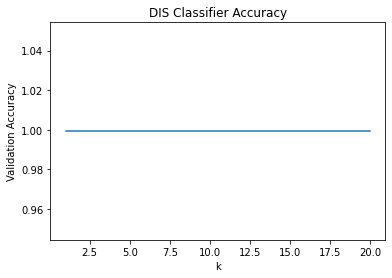

In [37]:
k_list= range(1,21)
accuracies=[]
for k in k_list:
  classifier = KNeighborsClassifier(n_neighbors= k, weights='distance', metric='euclidean')
  classifier.fit(train_x,train_y)
  train_pred=classifier.predict(train_x)
  accuracies.append(accuracy_score(train_y,train_pred))
plt.plot(k_list, accuracies)
plt.xlabel('k')
plt.ylabel('Validation Accuracy')
plt.title("DIS Classifier Accuracy")
plt.show()

# Euclidean, Uniform

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-

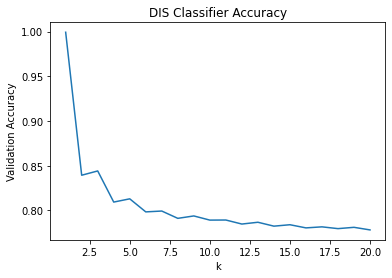

In [38]:
k_list= range(1,21)
accuracies=[]
for k in k_list:
  classifier = KNeighborsClassifier(n_neighbors= k , metric='euclidean')
  classifier.fit(train_x,train_y)
  train_pred=classifier.predict(train_x)
  accuracies.append(accuracy_score(train_y,train_pred))
plt.plot(k_list, accuracies)
plt.xlabel('k')
plt.ylabel('Validation Accuracy')
plt.title("DIS Classifier Accuracy")
plt.show()

# Minkowski, Distance

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-

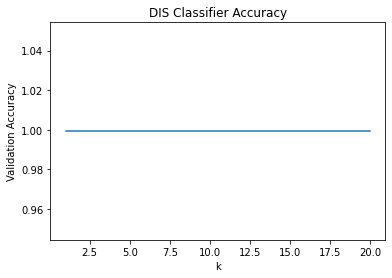

In [39]:
k_list= range(1,21)
accuracies=[]
for k in k_list:
  classifier = KNeighborsClassifier(n_neighbors= k, weights='distance', metric='minkowski')
  classifier.fit(train_x,train_y)
  train_pred=classifier.predict(train_x)
  accuracies.append(accuracy_score(train_y,train_pred))
plt.plot(k_list, accuracies)
plt.xlabel('k')
plt.ylabel('Validation Accuracy')
plt.title("DIS Classifier Accuracy")
plt.show()

# Minkowski, Uniform

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-

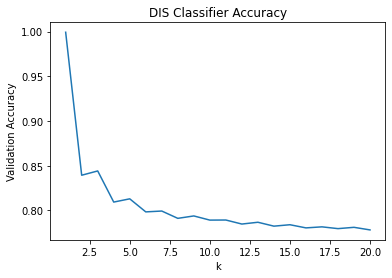

In [40]:
k_list= range(1,21)
accuracies=[]
for k in k_list:
  classifier = KNeighborsClassifier(n_neighbors= k, metric='minkowski')
  classifier.fit(train_x,train_y)
  train_pred=classifier.predict(train_x)
  accuracies.append(accuracy_score(train_y,train_pred))
plt.plot(k_list, accuracies)
plt.xlabel('k')
plt.ylabel('Validation Accuracy')
plt.title("DIS Classifier Accuracy")
plt.show()

# Manhattan, Distance

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-

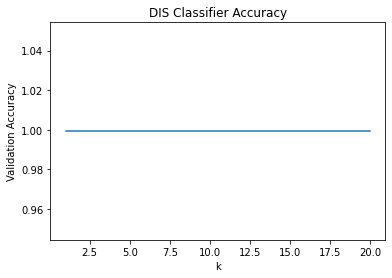

In [42]:
k_list= range(1,21)
accuracies=[]
for k in k_list:
  classifier = KNeighborsClassifier(n_neighbors= k, weights='distance', metric='manhattan')
  classifier.fit(train_x,train_y)
  train_pred=classifier.predict(train_x)
  accuracies.append(accuracy_score(train_y,train_pred))
plt.plot(k_list, accuracies)
plt.xlabel('k')
plt.ylabel('Validation Accuracy')
plt.title("DIS Classifier Accuracy")
plt.show()

# Manhattan, Uniform

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-

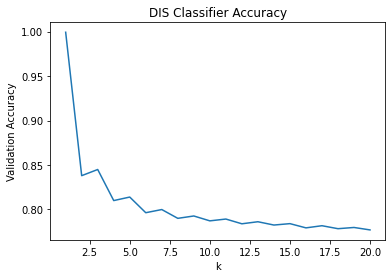

In [43]:
k_list= range(1,21)
accuracies=[]
for k in k_list:
  classifier = KNeighborsClassifier(n_neighbors= k, metric='manhattan')
  classifier.fit(train_x,train_y)
  train_pred=classifier.predict(train_x)
  accuracies.append(accuracy_score(train_y,train_pred))
plt.plot(k_list, accuracies)
plt.xlabel('k')
plt.ylabel('Validation Accuracy')
plt.title("DIS Classifier Accuracy")
plt.show()

# 그래프 결과 정리

Euclidean, Minkowski, Manhattan 이 세 가지 방법에 따라서 weight를 바꾸어 가며 살펴본 결과,

weight가 distance일때는 k값을 아무리 변화시켜도 성능지표들의 값이 1에 근접하게 머무는 것을 알 수 있다. 이 분류기가 k값에 영향을 거의 받지 않고 distance weight을 통해서 항상 과적합되어 있는 상태임을 알 수 있다.

또한, weight가 uniform일때는 k값이 증가함에 따라 점점 정확도가 떨어지는 모습을 보인다. 이 것은 분류기가 k값에 영향을 받긴하지만, k가 1에서 2가 되었을때 급격하게 정확도가 떨어지는 것을 봐선 이 데이터셋을 분류기가 잘 적합하지 못하고 있는(과소적합) 양상을 보여준다는 것을 알 수 있다.

즉, 지금 현존하는 문제는 weight를 주면 과대적합이 발생하고, weight를 빼면 과소 적합이 발생하고 있는 상황이다. 따라서 이를 다음과 같은 방법으로 해결하기로 한다.

#cross_val_predict를 이용한 과적합 문제 해결

이 함수는 k-겹 교차 검증을 수행하지만 평가 점수를 반환하는게 아니라, 각 테스트 폴드에서 얻은 예측을 반환한다.

그리고 이에 대해서  훈련세트의 모든 샘플에 대해서 깨끗한 예측을 얻게 된다.( 깨끗하다는 뜻은 모델이 훈련하는 동안 보지 못했던 데이터에 대해 예측했다는 말이다.)

다시 말해서, 분류기가 최적에 가깝게 설계되기 전까진 테스트 데이터를 사용하기엔 너무 이르니까, 트레인 데이터를 사용해서 비교-대조군을 형성했다는 뜻으로 받아들이면 편하다.

정리하자면, 위 데이터셋을 그대로 집어 넣는 것이 아니라 데이터셋 내에서도 fold라고 불리우는 일종의 군집을 만들어서 각각 군집들의 비교를 통해 과적합이 발생하지 않게 데이터를 교차검증 했다는 것이다.

# cross_validation 시작

# Euclidean, Distance

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:841: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:841: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:841: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:841: DataConversionWarning: A column-vector y was passed when

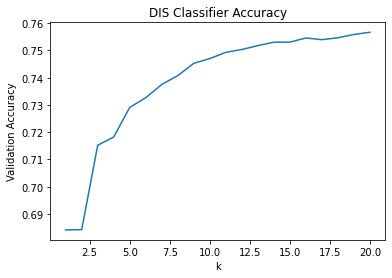

In [44]:
k_list= range(1,21)
accuracies=[]
for k in k_list:
  classifier = KNeighborsClassifier(n_neighbors= k, weights='distance', metric='euclidean')
  train_pred = cross_val_predict(classifier, train_x, train_y, cv=10)
  accuracies.append(accuracy_score(train_y,train_pred))
plt.plot(k_list, accuracies)
plt.xlabel('k')
plt.ylabel('Validation Accuracy')
plt.title("DIS Classifier Accuracy")
plt.show()

In [45]:
print('정확도 :',accuracy_score(train_y,train_pred))
print('정밀도 :',precision_score(train_y, train_pred))
print('재현율 :',recall_score(train_y,train_pred))
print('조화평균 :',f1_score(train_y, train_pred))

정확도 : 0.7566725757550655
정밀도 : 0.8008590998800356
재현율 : 0.6844490011906337
조화평균 : 0.7380922659914045


# Euclidean, Uniform

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:841: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:841: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:841: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:841: DataConversionWarning: A column-vector y was passed when

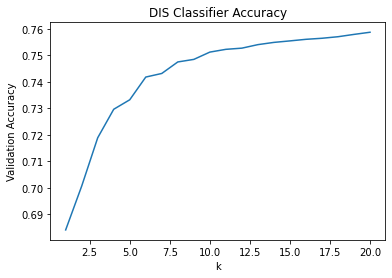

In [47]:
k_list= range(1,21)
accuracies=[]
for k in k_list:
  classifier = KNeighborsClassifier(n_neighbors= k, metric='euclidean')
  train_pred = cross_val_predict(classifier, train_x, train_y, cv=10)
  accuracies.append(accuracy_score(train_y,train_pred))
plt.plot(k_list, accuracies)
plt.xlabel('k')
plt.ylabel('Validation Accuracy')
plt.title("DIS Classifier Accuracy")
plt.show()

In [48]:
print('정확도 :',accuracy_score(train_y,train_pred))
print('정밀도 :',precision_score(train_y, train_pred))
print('재현율 :',recall_score(train_y,train_pred))
print('조화평균 :',f1_score(train_y, train_pred))

정확도 : 0.7586938153382263
정밀도 : 0.8225149207655896
재현율 : 0.660900912819156
조화평균 : 0.7329042196181988


# Minkowski, Distance

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:841: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:841: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:841: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:841: DataConversionWarning: A column-vector y was passed when

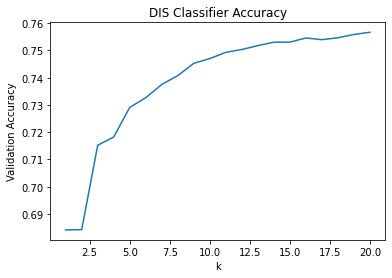

In [49]:
k_list= range(1,21)
accuracies=[]
for k in k_list:
  classifier = KNeighborsClassifier(n_neighbors= k, weights='distance', metric='minkowski')
  train_pred = cross_val_predict(classifier, train_x, train_y, cv=10)
  accuracies.append(accuracy_score(train_y,train_pred))
plt.plot(k_list, accuracies)
plt.xlabel('k')
plt.ylabel('Validation Accuracy')
plt.title("DIS Classifier Accuracy")
plt.show()

In [50]:
print('정확도 :',accuracy_score(train_y,train_pred))
print('정밀도 :',precision_score(train_y, train_pred))
print('재현율 :',recall_score(train_y,train_pred))
print('조화평균 :',f1_score(train_y, train_pred))

정확도 : 0.7566725757550655
정밀도 : 0.8008590998800356
재현율 : 0.6844490011906337
조화평균 : 0.7380922659914045


# Minkowski, Uniform

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:841: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:841: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:841: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:841: DataConversionWarning: A column-vector y was passed when

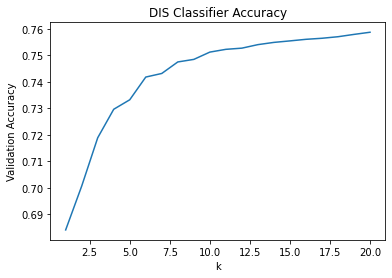

In [51]:
k_list= range(1,21)
accuracies=[]
for k in k_list:
  classifier = KNeighborsClassifier(n_neighbors= k, metric='minkowski')
  train_pred = cross_val_predict(classifier, train_x, train_y, cv=10)
  accuracies.append(accuracy_score(train_y,train_pred))
plt.plot(k_list, accuracies)
plt.xlabel('k')
plt.ylabel('Validation Accuracy')
plt.title("DIS Classifier Accuracy")
plt.show()

In [52]:
print('정확도 :',accuracy_score(train_y,train_pred))
print('정밀도 :',precision_score(train_y, train_pred))
print('재현율 :',recall_score(train_y,train_pred))
print('조화평균 :',f1_score(train_y, train_pred))

정확도 : 0.7586938153382263
정밀도 : 0.8225149207655896
재현율 : 0.660900912819156
조화평균 : 0.7329042196181988


# Manhattan, Distance

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:841: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:841: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:841: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:841: DataConversionWarning: A column-vector y was passed when

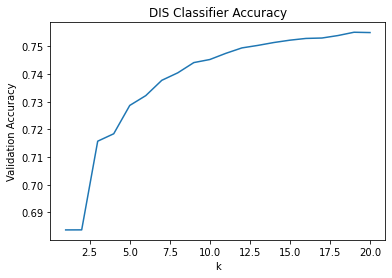

In [53]:
k_list= range(1,21)
accuracies=[]
for k in k_list:
  classifier = KNeighborsClassifier(n_neighbors= k, weights='distance', metric='manhattan')
  train_pred = cross_val_predict(classifier, train_x, train_y, cv=10)
  accuracies.append(accuracy_score(train_y,train_pred))
plt.plot(k_list, accuracies)
plt.xlabel('k')
plt.ylabel('Validation Accuracy')
plt.title("DIS Classifier Accuracy")
plt.show()

In [54]:
print('정확도 :',accuracy_score(train_y,train_pred))
print('정밀도 :',precision_score(train_y, train_pred))
print('재현율 :',recall_score(train_y,train_pred))
print('조화평균 :',f1_score(train_y, train_pred))

정확도 : 0.7550323895359433
정밀도 : 0.7995347033734005
재현율 : 0.6819685143537505
조화평균 : 0.7360868168350408


# Manhattan, Uniform

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:841: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:841: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:841: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:841: DataConversionWarning: A column-vector y was passed when

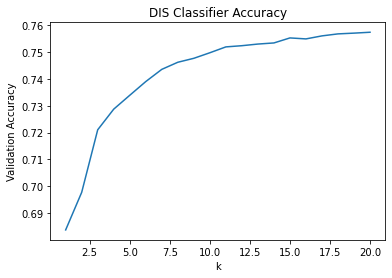

In [55]:
k_list= range(1,21)
accuracies=[]
for k in k_list:
  classifier = KNeighborsClassifier(n_neighbors= k, metric='manhattan')
  train_pred = cross_val_predict(classifier, train_x, train_y, cv=10)
  accuracies.append(accuracy_score(train_y,train_pred))
plt.plot(k_list, accuracies)
plt.xlabel('k')
plt.ylabel('Validation Accuracy')
plt.title("DIS Classifier Accuracy")
plt.show()

In [56]:
print('정확도 :',accuracy_score(train_y,train_pred))
print('정밀도 :',precision_score(train_y, train_pred))
print('재현율 :',recall_score(train_y,train_pred))
print('조화평균 :',f1_score(train_y, train_pred))

정확도 : 0.7574512500207095
정밀도 : 0.8225779763382146
재현율 : 0.6576597433522953
조화평균 : 0.7309318140047786


# cross_validation 결과 정리

결과적으로 weight가 uniform 일때 그리고 minkowski metric을 사용할때 정확도, 정밀도, 재현율, 조화평균이 모두 준수함을 알 수 있었다.

또한, 시각화 결과로부터 k수가 늘어남에 따라 점점 향상되는 모습을 보이긴 하지만, 기울기가 점점 작아지므로 20이상의 숫자를 찾는 것은 무의미하다고 판단했다.

따라서 최종적으로 cross_val을 통해 찾은 분류기는 k값이 20이고, weight은 디폴트 값인 uniform을 사용하며, metric은 minkowski을 사용하는 분류기 임을 알 수 있다.


In [57]:
classifier = KNeighborsClassifier(n_neighbors= 20, metric='minkowski')
train_pred=cross_val_predict(classifier, train_x, train_y, cv=10)
test_pred=cross_val_predict(classifier, test_x, test_y, cv=10)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:841: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:841: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:841: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:841: DataConversionWarning: A column-vector y was passed when

# 트레인 데이터셋에 대한 성능지표 확인

In [58]:
print('정확도 :',accuracy_score(train_y,train_pred))
print('정밀도 :',precision_score(train_y, train_pred))
print('재현율 :',recall_score(train_y,train_pred))
print('조화평균 :',f1_score(train_y, train_pred))

정확도 : 0.7586938153382263
정밀도 : 0.8225149207655896
재현율 : 0.660900912819156
조화평균 : 0.7329042196181988


# 테스트 데이터셋에 대한 성능지표 확인

In [59]:
print('정확도 :',accuracy_score(test_y,test_pred))
print('정밀도 :',precision_score(test_y, test_pred))
print('재현율 :',recall_score(test_y,test_pred))
print('조화평균 :',f1_score(test_y, test_pred))

정확도 : 0.7552669217982914
정밀도 : 0.817046004842615
재현율 : 0.6550706631464513
조화평균 : 0.7271473516355643


# KNeighbor 분류 결과 정리

결과적으로 위 데이터셋은 교차검증을 수행하지 않고 학습시킨다면 과대적합, 그리고 과소적합이 발생하는 데이터셋 임을 알 수 있었다. 그래서 이를 해결하기 위해서 cross_validation을 수행하였으며 결과적으로 k값이 20, weight이 unifrom이며 metric이 minkowski인 분류기를 구축할 수 있었다. 이에 대해서 트레인 데이터셋, 테스트 데이터셋들에 대한 성능지표 비교를 해보았으며 결과적으로 둘의 값이 비슷하게 나온 것을 통해 과적합 문제는 충분히 해결했음을 알 수 있다.

또한, 정확도, 정밀도의 값이 재현율 보다 높은데 이는 사실상 정밀도와 재현율 간의 trade-off관계로 인한 결과이다. 따라서 이 분류의 목적이 정밀도에 치중되어 있는지 혹은 재현율에 치중되어 있는지에 따라 다른 임곗값 설정을 통해 분류기를 다시 최적화 시키는 방향으로 진행해 볼 수 있다.

결과적으로는 우리가 고혈압 혹은 당뇨병 환자일 것이라고 예측한 것 중에서 진짜 고혈압, 당뇨병 환자일 확률은 0.81%를 과적합 문제없이 달성했다는 것에 의의가 있다.

# KNeighbor 회귀 시작

위의 연구에서는 혈당, 혈압 등의 수치를 이용해서 당뇨, 고혈압 등을 분류해 보았는데 이번에는 혈당, 혈압 그리고 당뇨, 고혈압 여부에 따른 BMI를 예측해 보기로한다.

실제로도 비만아니라도 평균 3% 체질량지수(BMI)를 줄여야 '당뇨병' 예방에도 효과적이라는 기사와 그에 대한 연구 결과가 있기 때문에 우리는 고혈압, 당뇨병 환자에 따른 BMI지수를 예측해보고자 위와 같은 연구를 진행하기로 하였다.

-출처 : 헬스조선 뉴스|서치클리닉, 이보람 헬스조선 기자, 2018,03,30

# 데이터셋들을 다시 병합해주고 타겟과 독립변수들을 나누어 준다.

In [63]:
train_x['DIS']=train_y
test_x['DIS']=test_y

In [65]:
train_y=train_x['BMI']
train_x=train_x.drop(['BMI'],axis=1)

test_y=test_x['BMI']
test_x=test_x.drop(['BMI'],axis=1)

# 회귀모델 시작, 위의 연구와 비슷한 방식으로 진행한다.

임의로 먼저 시행을 해보고 과적합 문제 발생시 이를 해결하는 쪽으로 진행한다.

In [73]:
reg=KNeighborsRegressor(n_neighbors=20, weights='distance', metric='euclidean')
reg.fit(train_x,train_y)
reg_pred=reg.predict(train_x)
reg_pred_test=reg.predict(test_x)

# 성능지표 계산을 위한 함수생성

In [74]:
def rmse(y_true, y_pred):
    return np.sqrt(((y_true - y_pred) ** 2).mean())
def mae(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred)))
def rerror(y_true, y_pred):
    return (y_true-y_pred)/y_true

# 임의로 시행한 결과 트레인 데이터와 테스트 데이터의 편차가 아주 심한 것을 알 수 있는데 이 역시 지금 회귀모델이 과대적합 문제를 겪고있는 것으로 판단할 수 있다.

In [75]:
print('RMSE :',rmse(train_y, reg_pred))
print('MAE :',mae(train_y, reg_pred))
print('Relative Error :',rerror(train_y, reg_pred).mean())

RMSE : 0.24424126155517067
MAE : 0.06521504429433374
Relative Error : 0.06525420388613917


In [76]:
print('RMSE :',rmse(test_y, reg_pred_test))
print('MAE :',mae(test_y, reg_pred_test))
print('Relative Error :',rerror(test_y, reg_pred_test).mean())

RMSE : 1.0178805412789387
MAE : 0.788998696121212
Relative Error : 0.9758863904954719


# 다시 cross_validation 시작

In [78]:
cross_pred=cross_val_predict(reg,train_x,train_y,cv=10)
print('RMSE :',rmse(train_y, cross_pred))
print('MAE :',mae(train_y, cross_pred))
print('Relative Error :',rerror(train_y, cross_pred).mean())

RMSE : 1.0142262752424869
MAE : 0.7878781749761657
Relative Error : 0.9747314557599542


In [79]:
cross_pred=cross_val_predict(reg,test_x,test_y,cv=10)
print('RMSE :',rmse(test_y, cross_pred))
print('MAE :',mae(test_y, cross_pred))
print('Relative Error :',rerror(test_y, cross_pred).mean())

RMSE : 1.002785377807631
MAE : 0.7809962649022342
Relative Error : 0.9451726457453944


# cross_validation 결과 과적합 문제가 상당히 많이 개선된 것을 확인할 수 있다.

위의 연구처럼 시각화를 통해 살펴보고 최적의 값을 도출해 본다.

#Euclidean, Distance

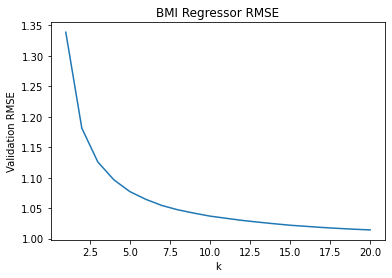

In [81]:
k_list= range(1,21)
rmses=[]
for k in k_list:
  reg=KNeighborsRegressor(n_neighbors=k, weights='distance', metric='euclidean')
  cross_pred=cross_val_predict(reg,train_x,train_y,cv=10)
  rmses.append(rmse(train_y,cross_pred))
plt.plot(k_list, rmses)
plt.xlabel('k')
plt.ylabel('Validation RMSE')
plt.title("BMI Regressor RMSE")
plt.show()

In [82]:
print('RMSE :',rmse(train_y, cross_pred))
print('MAE :',mae(train_y, cross_pred))
print('Relative Error :',rerror(train_y, cross_pred).mean())

RMSE : 1.0142262752424869
MAE : 0.7878781749761657
Relative Error : 0.9747314557599542


# Euclidean, Uniform

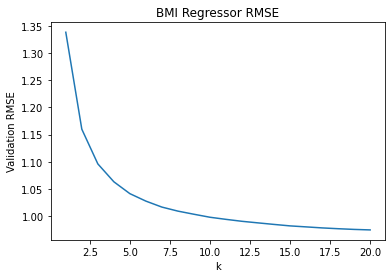

In [83]:
k_list= range(1,21)
rmses=[]
for k in k_list:
  reg=KNeighborsRegressor(n_neighbors=k, metric='euclidean')
  cross_pred=cross_val_predict(reg,train_x,train_y,cv=10)
  rmses.append(rmse(train_y,cross_pred))
plt.plot(k_list, rmses)
plt.xlabel('k')
plt.ylabel('Validation RMSE')
plt.title("BMI Regressor RMSE")
plt.show()

In [84]:
print('RMSE :',rmse(train_y, cross_pred))
print('MAE :',mae(train_y, cross_pred))
print('Relative Error :',rerror(train_y, cross_pred).mean())

RMSE : 0.9742681576005797
MAE : 0.7593681795989496
Relative Error : 0.9754463572305568


# Minkowski, Distance

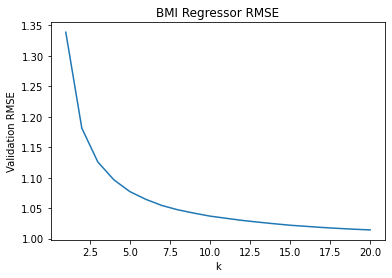

In [85]:
k_list= range(1,21)
rmses=[]
for k in k_list:
  reg=KNeighborsRegressor(n_neighbors=k, weights='distance', metric='minkowski')
  cross_pred=cross_val_predict(reg,train_x,train_y,cv=10)
  rmses.append(rmse(train_y,cross_pred))
plt.plot(k_list, rmses)
plt.xlabel('k')
plt.ylabel('Validation RMSE')
plt.title("BMI Regressor RMSE")
plt.show()

In [86]:
print('RMSE :',rmse(train_y, cross_pred))
print('MAE :',mae(train_y, cross_pred))
print('Relative Error :',rerror(train_y, cross_pred).mean())

RMSE : 1.0142262752424869
MAE : 0.7878781749761657
Relative Error : 0.9747314557599542


# Minkowski, Uniform

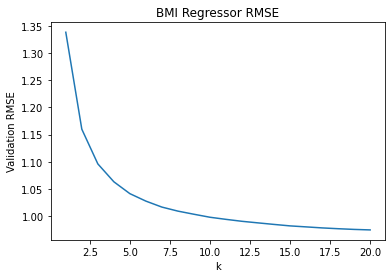

In [87]:
k_list= range(1,21)
rmses=[]
for k in k_list:
  reg=KNeighborsRegressor(n_neighbors=k, metric='minkowski')
  cross_pred=cross_val_predict(reg,train_x,train_y,cv=10)
  rmses.append(rmse(train_y,cross_pred))
plt.plot(k_list, rmses)
plt.xlabel('k')
plt.ylabel('Validation RMSE')
plt.title("BMI Regressor RMSE")
plt.show()

In [88]:
print('RMSE :',rmse(train_y, cross_pred))
print('MAE :',mae(train_y, cross_pred))
print('Relative Error :',rerror(train_y, cross_pred).mean())

RMSE : 0.9742681576005797
MAE : 0.7593681795989496
Relative Error : 0.9754463572305568


# Manhattan, Distance

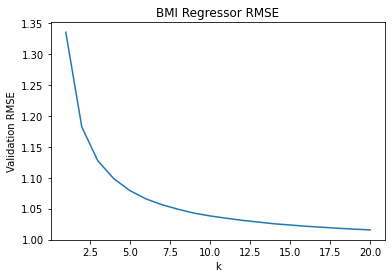

In [89]:
k_list= range(1,21)
rmses=[]
for k in k_list:
  reg=KNeighborsRegressor(n_neighbors=k, weights='distance', metric='manhattan')
  cross_pred=cross_val_predict(reg,train_x,train_y,cv=10)
  rmses.append(rmse(train_y,cross_pred))
plt.plot(k_list, rmses)
plt.xlabel('k')
plt.ylabel('Validation RMSE')
plt.title("BMI Regressor RMSE")
plt.show()

In [90]:
print('RMSE :',rmse(train_y, cross_pred))
print('MAE :',mae(train_y, cross_pred))
print('Relative Error :',rerror(train_y, cross_pred).mean())

RMSE : 1.0155564482635926
MAE : 0.7887497827009557
Relative Error : 0.9686544319617303


# Manhattan, Uniform

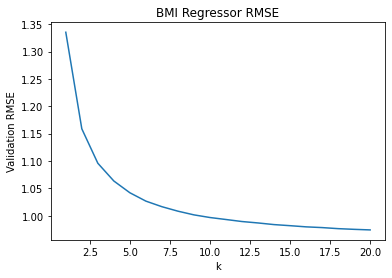

In [91]:
k_list= range(1,21)
rmses=[]
for k in k_list:
  reg=KNeighborsRegressor(n_neighbors=k, metric='manhattan')
  cross_pred=cross_val_predict(reg,train_x,train_y,cv=10)
  rmses.append(rmse(train_y,cross_pred))
plt.plot(k_list, rmses)
plt.xlabel('k')
plt.ylabel('Validation RMSE')
plt.title("BMI Regressor RMSE")
plt.show()

In [92]:
print('RMSE :',rmse(train_y, cross_pred))
print('MAE :',mae(train_y, cross_pred))
print('Relative Error :',rerror(train_y, cross_pred).mean())

RMSE : 0.9739405430843121
MAE : 0.7587079195505634
Relative Error : 0.9752544281321165


# 회귀모델 정리

분류 모델과 마찬가지로 교차검증을 수행했을때 과적합 문제를 해결할 수 있었다.
또한, k값이 줄어 들때 각종 성능지표들 또한 줄어드는 것을 확인할 수 있었는데, k값이 20에 다가갈수록 기울기가 줄어드는 양상을 확인할 수 있었기 때문에 20으로만 설정하였다.

결론적으로 RMSE, MAE, Relative Error를 확인해 보았을때 회귀모델의 경우 분류 모델과 마찬가지로 k값은 20, weight는 uniform, metric은 minkowski 모델이었음을 알 수 있다.

# 연관 분석

**[데이터]**

이 데이터셋은 kaggle에서 제공하는 bread basket 데이터 이다.
데이터에 대한 설명은 다음과 같다.

The dataset belongs to "The Bread Basket" a bakery located in Edinburgh. The dataset has 20507 entries, over 9000 transactions, and 4 columns.

**[항목]** 거래, 항목, 시간, 거래가 발생한 날의 때, 주말 or 평일


# 데이터 불러오기

In [116]:
helpme=pd.read_csv('./bread basket.csv')
helpme

,Transaction,Item,date_time,period_day,weekday_weekend
0,1,Bread,30-10-2016 09:58,morning,weekend
1,2,Scandinavian,30-10-2016 10:05,morning,weekend
2,2,Scandinavian,30-10-2016 10:05,morning,weekend
3,3,Hot chocolate,30-10-2016 10:07,morning,weekend
4,3,Jam,30-10-2016 10:07,morning,weekend
...,...,...,...,...,...
20502,9682,Coffee,09-04-2017 14:32,afternoon,weekend
20503,9682,Tea,09-04-2017 14:32,afternoon,weekend
20504,9683,Coffee,09-04-2017 14:57,afternoon,weekend
20505,9683,Pastry,09-04-2017 14:57,afternoon,weekend


# 필요한 칼럼만 추출하기, 그리고 리스트화 시키기

In [117]:
helpme=helpme[['Transaction','Item']]
helpme_array=[[]for i in range(9685)]
num=0
for i in helpme['Item']:
  helpme_array[helpme['Transaction'][num]].append(i)
  num+=1

# 리스트 확인해보기

첫 값이 []로 되어있는 것을 알 수 있는데 이는 transaction이 1부터 시작했기 때문이므로, pop을 통해 이 값을 제거해준다.

In [118]:
helpme_array

[[],
 ['Bread'],
 ['Scandinavian', 'Scandinavian'],
 ['Hot chocolate', 'Jam', 'Cookies'],
 ['Muffin'],
 ['Coffee', 'Pastry', 'Bread'],
 ['Medialuna', 'Pastry', 'Muffin'],
 ['Medialuna', 'Pastry', 'Coffee', 'Tea'],
 ['Pastry', 'Bread'],
 ['Bread', 'Muffin'],
 ['Scandinavian', 'Medialuna'],
 ['Bread', 'Medialuna', 'Bread'],
 ['Jam', 'Coffee', 'Tartine', 'Pastry', 'Tea'],
 ['Basket', 'Bread', 'Coffee'],
 ['Bread', 'Medialuna', 'Pastry'],
 ['Mineral water', 'Scandinavian'],
 ['Bread', 'Medialuna', 'Coffee'],
 ['Hot chocolate'],
 ['Farm House'],
 ['Farm House', 'Bread'],
 ['Bread', 'Medialuna'],
 ['Coffee', 'Coffee', 'Medialuna', 'Bread'],
 ['Jam'],
 ['Scandinavian', 'Muffin'],
 ['Bread'],
 ['Scandinavian'],
 ['Fudge'],
 ['Scandinavian'],
 ['Coffee', 'Bread'],
 ['Bread', 'Jam'],
 ['Bread'],
 ['Basket'],
 ['Scandinavian', 'Muffin'],
 ['Coffee'],
 ['Coffee', 'Muffin'],
 ['Muffin', 'Scandinavian'],
 ['Tea', 'Bread'],
 ['Coffee', 'Bread'],
 ['Bread', 'Tea'],
 ['Scandinavian'],
 ['Juice', 'Tarti

# null값 제거및 중복값 제거

In [119]:
helpme_array.pop(0)
num=0
for i in helpme_array:
  helpme_array[num] = list(set(helpme_array[num]))
  num+=1
helpme_array

[['Bread'],
 ['Scandinavian'],
 ['Hot chocolate', 'Cookies', 'Jam'],
 ['Muffin'],
 ['Bread', 'Pastry', 'Coffee'],
 ['Pastry', 'Medialuna', 'Muffin'],
 ['Pastry', 'Medialuna', 'Coffee', 'Tea'],
 ['Bread', 'Pastry'],
 ['Bread', 'Muffin'],
 ['Medialuna', 'Scandinavian'],
 ['Bread', 'Medialuna'],
 ['Tartine', 'Jam', 'Tea', 'Pastry', 'Coffee'],
 ['Bread', 'Coffee', 'Basket'],
 ['Pastry', 'Bread', 'Medialuna'],
 ['Mineral water', 'Scandinavian'],
 ['Bread', 'Medialuna', 'Coffee'],
 ['Hot chocolate'],
 ['Farm House'],
 ['Farm House', 'Bread'],
 ['Bread', 'Medialuna'],
 ['Bread', 'Medialuna', 'Coffee'],
 ['Jam'],
 ['Muffin', 'Scandinavian'],
 ['Bread'],
 ['Scandinavian'],
 ['Fudge'],
 ['Scandinavian'],
 ['Bread', 'Coffee'],
 ['Bread', 'Jam'],
 ['Bread'],
 ['Basket'],
 ['Muffin', 'Scandinavian'],
 ['Coffee'],
 ['Muffin', 'Coffee'],
 ['Muffin', 'Scandinavian'],
 ['Bread', 'Tea'],
 ['Bread', 'Coffee'],
 ['Bread', 'Tea'],
 ['Scandinavian'],
 ['Tartine', 'Juice', 'Coffee', 'Muffin'],
 ['Scandinavia

# 원-핫 인코딩 및 pivot테이블 형성

In [120]:
rules=TransactionEncoder()
rule_arr=rules.fit_transform(helpme_array)
helme=pd.DataFrame(rule_arr, columns=rules.columns_)
helme

,Adjustment,Afternoon with the baker,Alfajores,Argentina Night,Art Tray,Bacon,Baguette,Bakewell,Bare Popcorn,Basket,Bowl Nic Pitt,Bread,Bread Pudding,Brioche and salami,Brownie,Cake,Caramel bites,Cherry me Dried fruit,Chicken Stew,Chicken sand,Chimichurri Oil,Chocolates,Christmas common,Coffee,Coffee granules,Coke,Cookies,Crepes,Crisps,Drinking chocolate spoons,Duck egg,Dulce de Leche,Eggs,Ella's Kitchen Pouches,Empanadas,Extra Salami or Feta,Fairy Doors,Farm House,Focaccia,Frittata,...,Lemon and coconut,Medialuna,Mighty Protein,Mineral water,Mortimer,Muesli,Muffin,My-5 Fruit Shoot,Nomad bag,Olum & polenta,Panatone,Pastry,Pick and Mix Bowls,Pintxos,Polenta,Postcard,Raspberry shortbread sandwich,Raw bars,Salad,Sandwich,Scandinavian,Scone,Siblings,Smoothies,Soup,Spanish Brunch,Spread,Tacos/Fajita,Tartine,Tea,The BART,The Nomad,Tiffin,Toast,Truffles,Tshirt,Valentine's card,Vegan Feast,Vegan mincepie,Victorian Sponge
0,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9679,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,Fa

# 연관분석을 위한 데이터 프레임 생성 및 분석 실시

In [122]:
frequency=apriori(helme, min_support=0.05, use_colnames=True)
frequency

,support,itemsets
0,0.319806,(Bread)
1,0.101508,(Cake)
2,0.467575,(Coffee)
3,0.053181,(Cookies)
4,0.057001,(Hot chocolate)
5,0.060409,(Medialuna)
6,0.084159,(Pastry)
7,0.070219,(Sandwich)
8,0.139405,(Tea)
9,0.087980,"(Bread, Coffee)"


# confidence

In [130]:
association_rules(frequency, metric='confidence', min_threshold=0.1)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Bread),(Coffee),0.319806,0.467575,0.08798,0.275105,0.588365,-0.061553,0.734485
1,(Coffee),(Bread),0.467575,0.319806,0.08798,0.188163,0.588365,-0.061553,0.837845
2,(Cake),(Coffee),0.101508,0.467575,0.05349,0.526958,1.127002,0.006028,1.125534
3,(Coffee),(Cake),0.467575,0.101508,0.05349,0.114399,1.127002,0.006028,1.014557


# lift

In [124]:
association_rules(frequency, metric='lift', min_threshold=1)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Cake),(Coffee),0.101508,0.467575,0.05349,0.526958,1.127002,0.006028,1.125534
1,(Coffee),(Cake),0.467575,0.101508,0.05349,0.114399,1.127002,0.006028,1.014557


# 연관 분석 결과 정리

support(전체 거래 중 A와 B를 포함하는 거래는 어느 정도인가)
confidence(A를 포함하는 거래 중에서 B가 포함된 거래는 어느정도인가)
Lift(A와 B 가 같이 나오는 비율을 X가 나올 비율과 Y가 나올 비율의 곱으로 나눈 값) -> A와 B의 연관도 확인 가능! (lift>1 positive correlation, 1 independent, lift<1 negative correlation)

위의 결과에서 lift가 1이상인 라인만을 추출했을 때, (cake, coffee)와 (coffee, cake)가 추출되는 것을 확인 할 수 있다. 
1이상의 lift를 가지는 것을 볼 때, cake와 coffee가 양의 상관관계를 가지고, 손님들이 주로 cake와 coffee를 같이 먹는 것을 확인 할 수 있다. 이때, 해당 주문이 전체 주문에서 차지하는 비율은 support = 0.05349로 약 5.3%이다.

Confidence를 확인해보면 (cake, coffee)가 0.526958, (coffee, cake)가 0.14399로, 주로 ‘cake’를 포함하는 주문에 ‘coffee’가 같이 포함되는 관계라는 것을 알 수 있다. 
위와 같은 결과를 통해 cake를 먹는 사람들의 약 52.6%는 커피를 마신다는 것을 확인 할 수 있기 때문에, 케이크와 커피를 묶어서 세트 메뉴로 판매(가격 할인)하는 등의 프로모션을 통해 고객에게 매력적인 서비스를 제공하거나, 판매량을 늘리고 싶은 케이크 종류와 커피를 세트로 묶어 해당 케이크 종류의 판매량 증대를 노릴 수 있을 것이다. 

(bread, coffee)  와 (cake,coffee) 를 비교할 때, confidece에 비해 lift 가 낮게 나타나는 이유는 bread 와 coffee  각각의 판매 빈도가 높게 나타나기 때문이다. 즉, (bread, coffee) 의 lift 가 1 이하로 나타난 다는 것은 bread 와 coffee 를 동시에 구매하기보다는 각각의 제품을 구매할 확률이 높다는 것이다. 
주로 커피 만을 선택했던 고객층들을 공략하기 위해서는 브래드 보다는 케이크와의 연계 상품이 더욱 효과적일듯하다. (lift 의 값 때문에)

실제로 '무슨일이조'가 조사한 결과, 4층 빵집이라는 스타트업은 베이킹 시설이 없는 카페에 맞춤 케이크를 아웃소싱으로 공급하고 공급받은 카페는 고객에게 케이크를 먼저 구매하고 커피를 선택하는 주문 flow를 통해 매출 증대를 만드는 구조를 통해 비즈니스를 이어가고 있다. '무슨 일이조'가 분석한 것처럼, 케이크 주문 후 커피 주문율은 높기 때문에 자연스레 커피만 판매하던 것보다 매출 증대를 불러오기 때문이다.

# Team Review

우리조는 CBR을 통해 당뇨, 고혈압에 관한 분석을 실시하였다. 이번 연구에 있어서 적당하고 풍부한 데이터셋을 확보함으로써 보다 수월한 연구가 진행될 수 있었고 모델의 피쳐에 따른 과대 적합, 혹은 과소적합 여부를 시각화와 값의 비교를 통해 밝혀내고 이를 cross_validation을 통해서 해결하는 과정을 진행하였다. 한 가지 아쉬운 점은 당뇨 , 고혈압에 대한 다른 변수들의 갯수가 다소 적다고 느껴졌다는 것이다. 

AR을 통해서는 아이템 간의 관계를 파악하고 이를 통한 판매 전략등을 세워볼 수 있었다. 한 가지 흥미로웠던 점은, 숫자로만 된 데이터셋이 아니라 Coffe, Bread 등과 같이 기존과는 조금 다른 데이터셋을 다뤄봤다는 점에서 흥미로웠으며 단순히 거래량, 그리고 항목만을 통해서 규칙을 발견해낼 수 있다는 점이 유익했다.
이 또한 아쉬운 점이 있는데, 빵과 커피라는 것은 어떻게 보면 쉽게 떠올릴 수 있는 조합이다. 따라서 좀더 새로운 데이터셋을 찾아내 다른 결과를 이끌어냈다면 좀더 유익했을 것이라는 아쉬움이 있다.

# References

당뇨병, 고혈압과 BMI에 관한 기사 출처: https://m.health.chosun.com/svc/news_view.html?contid=2018033001554

국민건강검진데이터 출처 : https://nhiss.nhis.or.kr/bd/ab/bdabf003cv.do

bread basket 데이터 출처 : https://www.kaggle.com/mittalvasu95/the-bread-basket?select=bread+basket.csv

